# The Effects of Marketing Decisions using the Bank Marketing Dataset

The [UCI Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) comes from a real-world bank's direct marketing campaign. It is a popular dataset most commonly treated as a classification task, to predict whether a client will open a term deposit account. In this notebook, we show that it is equally suitable for causal inference. The fraction of clients making term deposits is an *outcome* that the bank would like to increase, and the dataset contains several variables that could be seen as *interventions* or *treatments* (we will use the terms interchangeably) for doing so.  

1. [Understand Data](#data)
    1. [Identify treatment variables](#data-treatment)
    2. [Identiy potential confounders](#data-confounders)
2. [Effect of Contact Mode](#contact)
    1. [Inverse propensity weighting: First attempt](#contact-ipw1)
    2. [Characterizing the region of treatment non-overlap using rules](#contact-non-overlap)
    3. [Inverse propensity weighting: After excluding non-overlap region](#contact-ipw2)
    4. [Standardization](#contact-standardization)
    5. [Summary and comparison with non-causal analysis](#contact-summary)
3. [Effect of Number of Contacts](#campaign)
    1. [Redefine treatment variable and potential confounders](#campaign-treatment-confounders)
    2. [A closer look at the intervention scenario](#campaign-closer-look)
    3. [Inverse propensity weighting](#campaign-ipw)
    4. [Standardization](#campaign-standardization)
    5. [Summary](#campaign-summary)

<a id='data'></a>

## 1. Understand Data

Load the data:

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('../Data/bank-additional/bank-additional-full.csv', sep=';')
data.shape

(41188, 21)

The first step is to understand what variables are present in the data.

In [2]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

According to the [data description](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing):
* The first seven variables (`'age'`-`'loan'`) relate to the client, including basic credit characteristics (`'default'`, `'housing'`, `'loan'`).
* The next four variables relate to the last contact with the client during the current campaign: the mode of communication (`'contact'`, cellular/telephone), date (`'month'`, `'day_of_week'`), and duration of the contact (`'duration'`). `'campaign'` is the number of contacts made during this campaign.
* The three subsequent variables relate to previous marketing campaigns, if applicable: the number of days since the last contact from a previous campaign (`'pdays'`), the number of contacts in previous campaigns (`'previous'`), and their outcome (`'poutcome'`).
* Variables `'emp.var.rate'`-`'nr.employed'` are economic indicators such as the employment rate and consumer price index.
* The last variable `'y'` is the outcome of whether the client opened a term deposit.

We go ahead and binarize `'y'`, mapping `'yes'` to value 1.

In [3]:
print(data['y'].unique())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(data['y']))
y.mean()

['no' 'yes']


0.11265417111780131

Only 11.3% of clients sign up for a term deposit.

<a id='data-treatment'></a>

### Identify treatment variables

Next, we consider which of the above variables could be regarded as interventions, undertaken by bank employees, to increase the rate of positive outcomes. These are immediately limited to the variables associated with the current campaign, since client characteristics and economic conditions cannot be controlled by the bank, nor can past events be changed. In addition, as discussed [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing), `'duration'` is not known until the last contact is completed and is mostly determined by the client. Of the remaining variables, in this notebook we will investigate the effects of `'contact'` (mode of communication) and `'campaign'` (number of contacts). `'day_of_week'` can be treated similarly as `'contact'`, as indicated below.

We consider `'contact'` first and encode it as a 0/1-valued variable `a` (0 for cellular, 1 for telephone):

In [4]:
print(data['contact'].unique())
a = pd.Series(le.fit_transform(data['contact']))
a.mean()

['telephone' 'cellular']


0.3652520151500437

<a id='data-confounders'></a>

### Identify potential confounders

To estimate causal effects from observational data, we must also identify which of the variables are potential *confounders*, variables that could affect both the outcome `'y'` as well as the decision to intervene. We will want to "adjust for" (i.e. control) these confounders to isolate the causal effect of the intervention on `'y'`. For this dataset, confounder selection can be done by:
1. Following the rule of thumb of avoiding post-intervention variables, i.e., those that may be affected by the intervention, and 
2. Putting ourselves in the shoes of the hypothetical bank employee who made the decision. 

Consideration 1 eliminates `'duration'` since it is a result of the last contact with the client. On the flip side, we will always include as potential confounders:
* Client characteristics `'age'`-`'loan'`: These clearly affect the client's decision to invest in a term deposit (the outcome). We assume that the bank may also have most of this information in their records and a bank employee may consult it in contacting the client.
* Previous campaigns `'pdays', 'previous', 'poutcome'`: These indicate the client's previous receptiveness to the bank's products and would also be part of the client's record.
* Economic indicators `'emp.var.rate'`-`'nr.employed'`: These conditions may influence the client's decision as well as the bank's practices.

In [5]:
confounders = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

For the `'contact'` intervention, the decision is whether the bank employee should call a cell phone or landline as the next (and last) contact with the client. Thus we will also include as potential confounders `'month'`, to account for any seasonality effects, and `'campaign'`, the number of contacts up until this point.

In [6]:
confounders += ['month', 'campaign']

We will discuss the `'campaign'` intervention later below.

Now we just extract the confounders into a variable `X` and dummy-code (aka one-hot code) the categorical ones in preparation for modelling.

In [7]:
X = data[confounders]
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
month              object
campaign            int64
dtype: object

In [8]:
X = pd.get_dummies(X, prefix_sep='=', drop_first=True)
X.head()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign,job=blue-collar,...,poutcome=success,month=aug,month=dec,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep
0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,57,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,37,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,40,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0


<a id='contact'></a>

## 2. Effect of Contact Mode

We have actually done a good part of the hard work, namely understanding the data and identifying the treatment variables and confounders. Now we can put the tools of Causal Inference 360 to work.

We will first study the causal effect of contact mode `'contact'`. Specifically, we will consider the average causal effect, comparing the rate of positive outcomes (term deposits opened) that would result if everyone had been contacted by cell phone versus the rate if everyone had been contacted by landline. 

We will estimate the effect in two different ways: inverse propensity weighting (IPW) and standardization. You can look at their respective notebooks ([IPW](https://github.com/IBM/causallib/blob/master/examples/ipw.ipynb), [standardization](https://github.com/IBM/causallib/blob/master/examples/standardization.ipynb)) for more details on each and also try a third method on your own, namely [doubly robust regression](https://github.com/IBM/causallib/blob/master/examples/doubly_robust.ipynb). Recall that in causal inference from observational data, the true causal effect is never known: for each client, we observe only one outcome corresponding to the intervention they were assigned, and we cannot go back in time and run a randomized experiment (randomly assigning clients to interventions). By estimating the effect in different ways, relying on different assumptions, we can increase confidence in the results we obtain if they are close to each other.

<a id='contact-ipw1'></a>

### Inverse propensity weighting: First attempt

Inverse propensity weighting (IPW) requires a model for estimating the probabilities of treatment assignments given the confounders `X` (known as *propensities*). Here we will start with plain logistic regression.

In [9]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
#lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
#lr = GradientBoostingClassifier()
ipw = IPW(lr)

Fit the model:

In [10]:
ipw.fit(X, a)

IPW(truncate_eps=None, use_stabilized=False,
    learner=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False))

Estimating the rates of positive outcomes under the two interventions (0 if everyone is contacted by cell phone, 1 by landline) is then simply a matter of calling the `estimate_population_outcome` method of the IPW object.

In [11]:
outcomes = ipw.estimate_population_outcome(X, a, y)
outcomes

1    0.218004
0    0.155610
dtype: float64

However, before we accept this result, we have to check the IPW model for any problems that we can detect with the observed data. We do this using Causal Inference 360's `PropensityEvaluator` and ask it to produce four plots.

/Users/denniswei/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/denniswei/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


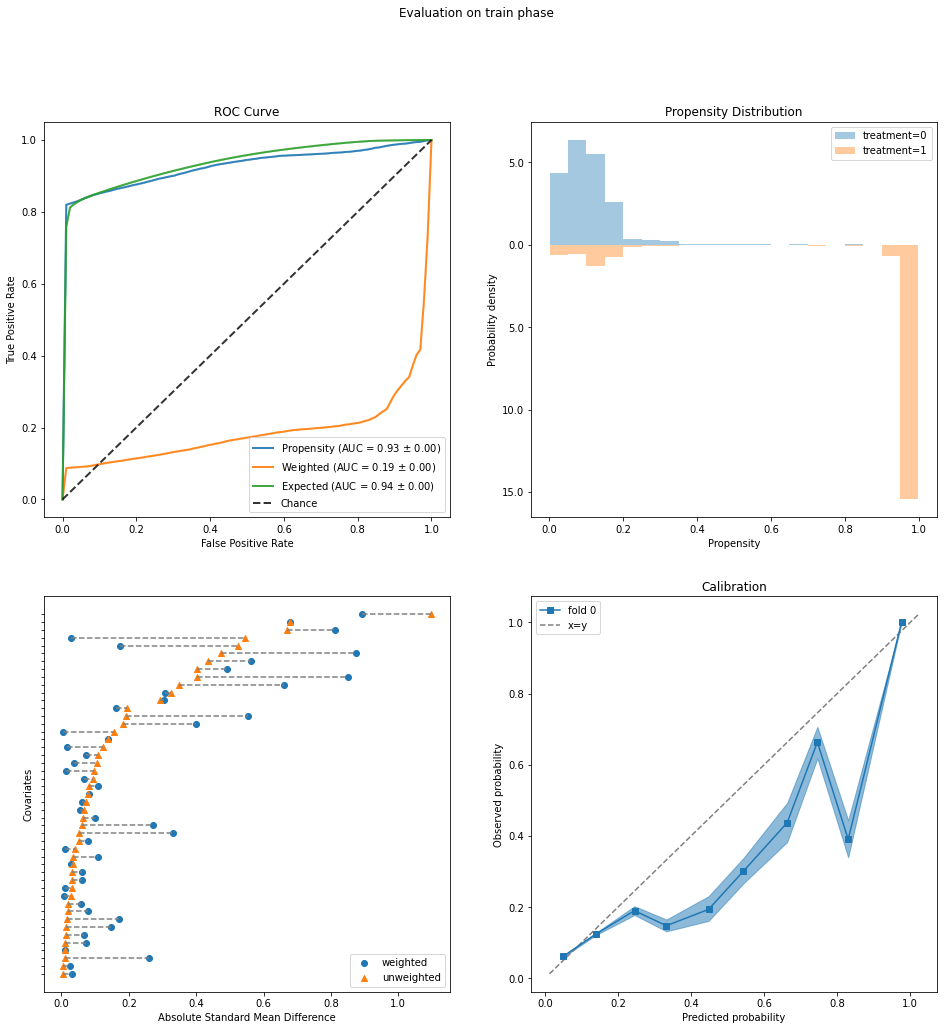

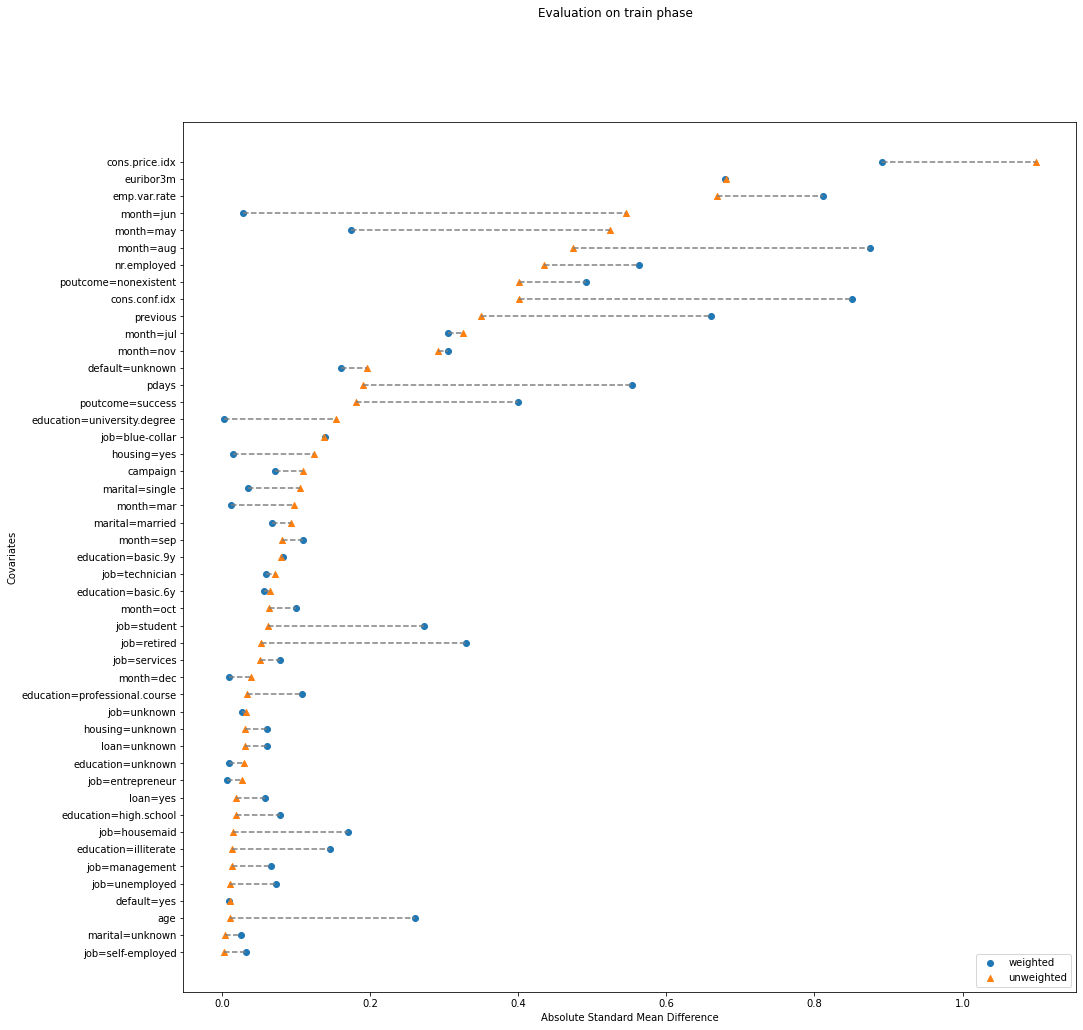

In [12]:
%matplotlib inline
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])
evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

The `PropensityEvaluator` plots show the following problems:
* **ROC Curve**: The blue curve labelled "Propensity" is the standard ROC for predicting treatment `a` from the confounders `X`. In normal classification, we want a high AUC value close to 1, but for causal inference, an AUC that is too high (0.93 here) indicates that the two treatment groups (cellular/telephone) are too easily separated. In particular, the vertical segment at the left end of the ROC indicates that we can correctly identify a large fraction of telephone contacts (true positives) with hardly any cellular contacts mixed in (false positives). In addition, the orange curve labelled "Weighted" should ideally have an AUC of 0.5, meaning that the two treatment groups become indistinguishable after the propensity weighting is applied. The current AUC of 0.19 is way off.
* **Propensity Distribution**: This plot shows the distributions of propensity values for `a=1` (estimated probability of being contacted by telephone) for the two treatment assignment groups: cellular (blue) and telephone (orange). The large orange bars at the right without any blue bars above them again point to the existence of a population that was essentially always contacted by telephone and never by cellular.
* **Covariate Balance** (bottom left): The orange triangles in this plot (called a *Love plot*) show that the two treatment groups have large differences in the mean values of some of the covariates (confounders). Re-plotting the Love plot by itself, we see that the largest differences are in the economic indicators `'cons.price.idx'`, `'euribor3m'`, `'emp.var.rate'`. Furthermore, the propensity weighting has not really succeeded in reducing these differences (blue circles).

Taken together, the `PropensityEvaluator` shows a *lack of overlap* between the two treatment groups, and specifically a group of clients that was almost always contacted by telephone. It is not advisable to estimate causal effects in regions where we do not have treatment overlap, unless we are willing to make strong assumptions about how outcomes extrapolate from one region to another (i.e., what would be the outcome under the cellular treatment for the group that was always contacted by telephone).

To proceed, we will exclude this group of telephone-only contacts and try again. The Propensity Distribution plot above suggests that this could be done simply by thresholding the estimated propensity values (at say 0.9). To gain more insight, we will instead use a rule set learner from IBM's AI Explainability 360 (AIX360) toolkit to describe this group by a small number of rules.

<a id='contact-non-overlap'></a>

### Characterizing the region of treatment non-overlap using rules

We use [AIX360](https://github.com/Trusted-AI/AIX360)'s Boolean Rules via Column Generation (BRCG) method to learn a set of rules for predicting `a=1` (telephone contact) based on the confounders `X`. To learn more about BRCG, please see the [documentation](https://aix360.readthedocs.io/en/latest/dise.html#aix360.algorithms.rbm.boolean_rule_cg.BooleanRuleCG) and [paper](https://papers.nips.cc/paper/2018/hash/743394beff4b1282ba735e5e3723ed74-Abstract.html). If you do not wish to install and run AIX360, you can simply skip the following cell.

In [13]:
from aix360.algorithms.rbm import BooleanRuleCG, FeatureBinarizer
fb = FeatureBinarizer(negations=True)
X_fb = fb.fit_transform(X)
br = BooleanRuleCG()
br.fit(X_fb, a)

from sklearn.metrics import accuracy_score, roc_auc_score
aPred = br.predict(X_fb)
print('Accuracy: {}'.format(accuracy_score(a, aPred)))
print('AUC: {}'.format(roc_auc_score(a, aPred)))
print(br.explain()['rules'])

Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.0930
Accuracy: 0.92942119063805
AUC: 0.9033834086679075
['cons.price.idx > 93.92 AND euribor3m > 1.41']


The last line above shows that the returned rule set consists of only a single rule with two conditions on `'cons.price.idx'` and `'euribor3m'`. This single rule already predicts `a` very well, as seen from the accuracy and AUC values. Not coincidentally, in the Love plot in the previous subsection, `'cons.price.idx'` and `'euribor3m'` are also the covariates with the largest mean difference between the treatment groups. We will simply use this rule as the criteria for excluding individuals from the analysis.

In [14]:
indExclude = (X['cons.price.idx'] > 93.92) & (X['euribor3m'] > 1.41)
a[indExclude].mean()

1.0

We see in fact that in every instance satisfying the rule, the client was contacted by telephone. It is not clear why this is the case without more specific knowledge of the dataset. We can infer that this occurred during a time of higher inflation and interest rates: The consumer price index `'cons.price.idx'` is a standard measure of inflation, while Euribor `'euribor3m'` is a Eurozone interbank lending rate and a benchmark for short-term interest rates.

Removing instances that satisfy the rule:

In [15]:
y = y.loc[~indExclude]
a = a.loc[~indExclude]
X = X.loc[~indExclude]
print(y.mean())
print(a.mean())

0.14498640322192008
0.1000654022236756


The fraction of telephone contacts has gone down significantly after the exclusion, and the rate of positive outcomes has also increased.

<a id='contact-ipw2'></a>

### Inverse propensity weighting: After excluding non-overlap region

We now re-fit and re-evaluate the IPW model after removing the non-overlap region identified above.

In [16]:
ipw.fit(X, a)

IPW(truncate_eps=None, use_stabilized=False,
    learner=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False))

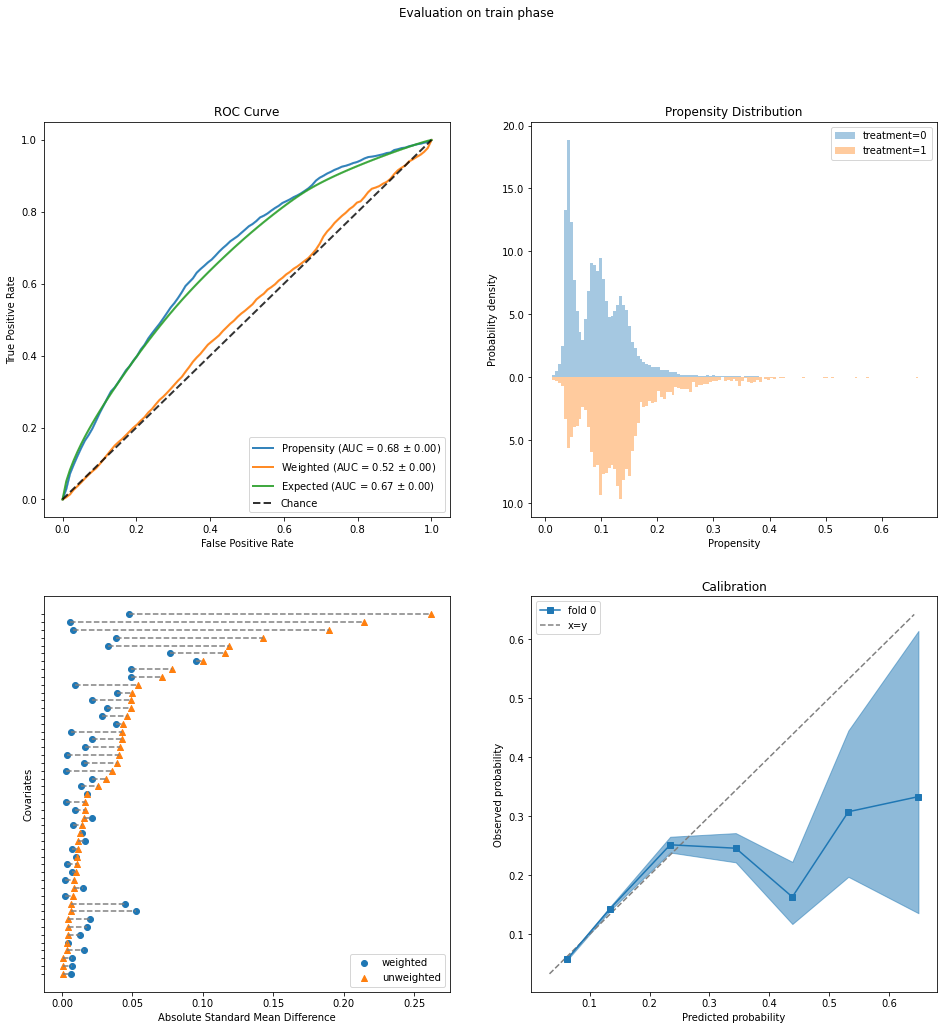

In [17]:
evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])

The evaluation looks much better.
* **ROC Curve**: The original AUC of 0.68 ("Propensity", blue curve) is not too high, and the weighted AUC (orange) is close to 0.5.
* **Propensity Distribution**: No more large orange bars that do not overlap with blue ones.
* **Covariate Balance Love Plot**: The starting mean differences are now much smaller, below 0.3 on this standardized scale, and are decreased to below 0.1 by propensity weighting.
* **Calibration**: The calibration curve does deviate significantly from the ideal y=x line. However, this occurs above a predicted probability of 0.3, which the Propensity Distribution plot above shows is very infrequent, so it is not too much of a concern.

Armed with greater confidence from these improved `PropensityEvaluator` results, we re-estimate the rates of positive outcomes under the two interventions.

In [18]:
outcomes = ipw.estimate_population_outcome(X, a, y)
print(outcomes)
ipw.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

1    0.120666
0    0.150452
dtype: float64


diff     0.029786
ratio    1.246846
dtype: float64

We conclude from the IPW analysis that contacting clients by cell phone results in a higher rate of opening term deposits than by landline, 15% to 12%, a difference of 3.0% and a relative increase of almost 25%.

<a id='contact-standardization'></a>

### Standardization

Next we turn to standardization as a second method for estimating the causal effect of contact mode. We will continue to exclude the telephone-only group identified [above](#contact-non-overlap) to avoid having to extrapolate.

Standardization requires a model for estimating the *outcome* `y` given intervention `a` and confounders `X`. We will use gradient-boosted classification trees as well as the `predict_proba=True` option to focus on predicting probabilities of outcomes.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from causallib.estimation import Standardization

#gb = LinearRegression()
gb = GradientBoostingClassifier()
std = Standardization(gb, predict_proba=True)
std.fit(X, a, y)

Standardization(encode_treatment=False, predict_proba=True,
                learner=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False))

In [20]:
outcomes = std.estimate_population_outcome(X, a).xs(1, level='y')
print(outcomes)
std.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

a
1    0.116832
0    0.150320
dtype: float64


diff     0.033488
ratio    1.286636
dtype: float64

These values are similar to the ones obtained with IPW: an absolute increase of 3.4% in positive outcomes with cellular contact compared to landline, and a relative increase of 29%.

Causal Inference 360 provides an `OutcomeEvaluator` class to evaluate standardization models, similar to `PropensityEvaluator` for propensity weighting models. We apply `OutcomeEvaluator` below.

/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric accuracy could not be evaluated
  warnings.warn('metric {} could not be evaluated'.format(metric_name))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:122: UserWarning: Classification metrics can't handle a mix of binary and continuous targets
  warnings.warn(str(v))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric precision could not be evaluated
  warnings.warn('metric {} could not be evaluated'.format(metric_name))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric recall could not be evaluated
  warnings.warn('metric {} could not be evaluated'.format(metric_name))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric f1 could not be evaluated
  warnings.warn(

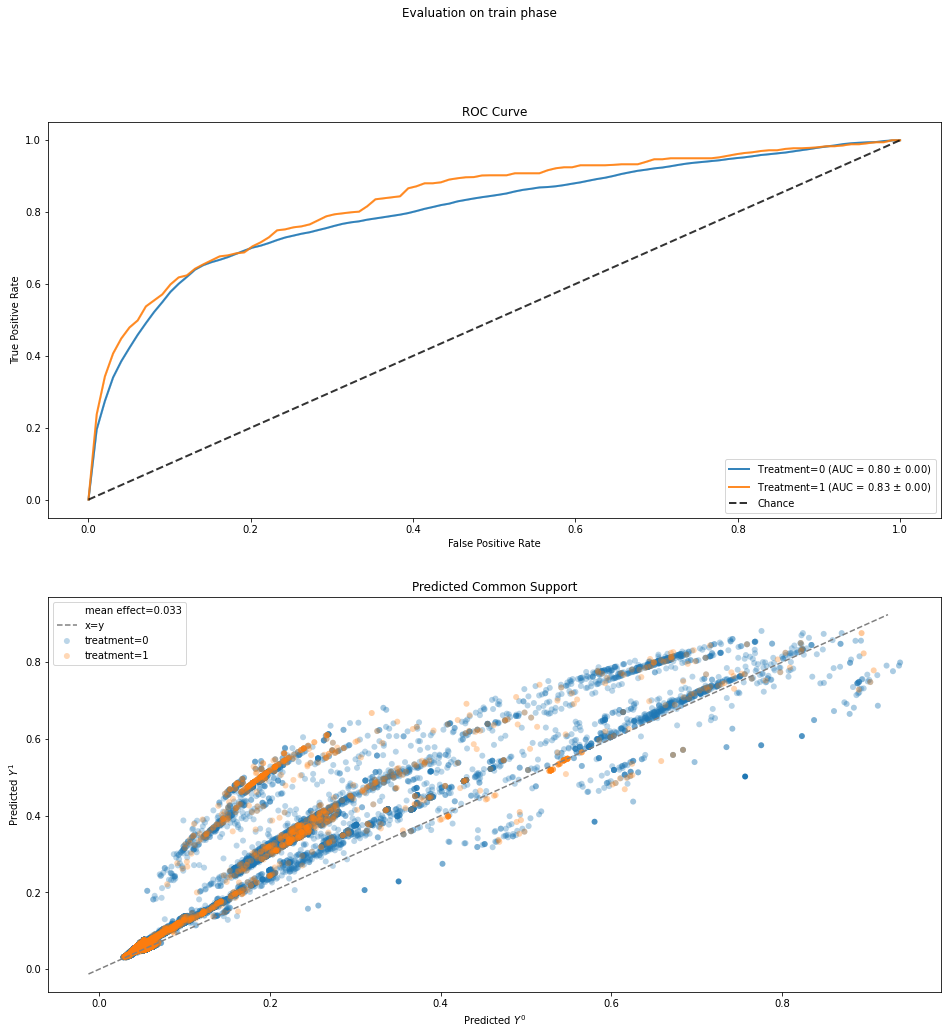

In [21]:
from causallib.evaluation import OutcomeEvaluator
evaluator = OutcomeEvaluator(std)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve","common_support"])

* **ROC Curve**: The AUC in predicting outcome `y` is reasonably high and similar for both treatment groups. 
* **Predicted Common Support**: This plot is meant to assess the ignorability assumption, which states that the counterfactual outcomes (Y<sup>0</sup>, Y<sup>1</sup>) are independent of the actual treatment assignment when conditioned on the confounders. The plot shows the distributions of predicted (Y<sup>0</sup>, Y<sup>1</sup>) values and we are looking for good overlap between the distributions for treatment groups 0 (blue) and 1 (orange). This appears to be the case.

The `Standardization` class uses a single regressor that takes input (`X`, `a`) to predict `y`, i.e., the intervention `a` is placed on the same footing as other input features in `X`. Alternatively, `StratifiedStandardization` uses two regressors, one for `a=0` and one for `a=1`, each of which take `X` as input.

In [22]:
from causallib.estimation import StratifiedStandardization
std = StratifiedStandardization(gb, predict_proba=True)
std.fit(X, a, y)

outcomes = std.estimate_population_outcome(X, a).xs(1, level='y')
print(outcomes)
std.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

a
1    0.113203
0    0.150328
dtype: float64


diff     0.037125
ratio    1.327954
dtype: float64

The resulting estimates are a bit higher than those from `Standardization`.

/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric accuracy could not be evaluated
  warnings.warn('metric {} could not be evaluated'.format(metric_name))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:122: UserWarning: Classification metrics can't handle a mix of binary and continuous targets
  warnings.warn(str(v))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric precision could not be evaluated
  warnings.warn('metric {} could not be evaluated'.format(metric_name))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric recall could not be evaluated
  warnings.warn('metric {} could not be evaluated'.format(metric_name))
/Applications/anaconda3/lib/python3.7/site-packages/causallib/evaluation/evaluator.py:121: UserWarning: metric f1 could not be evaluated
  warnings.warn(

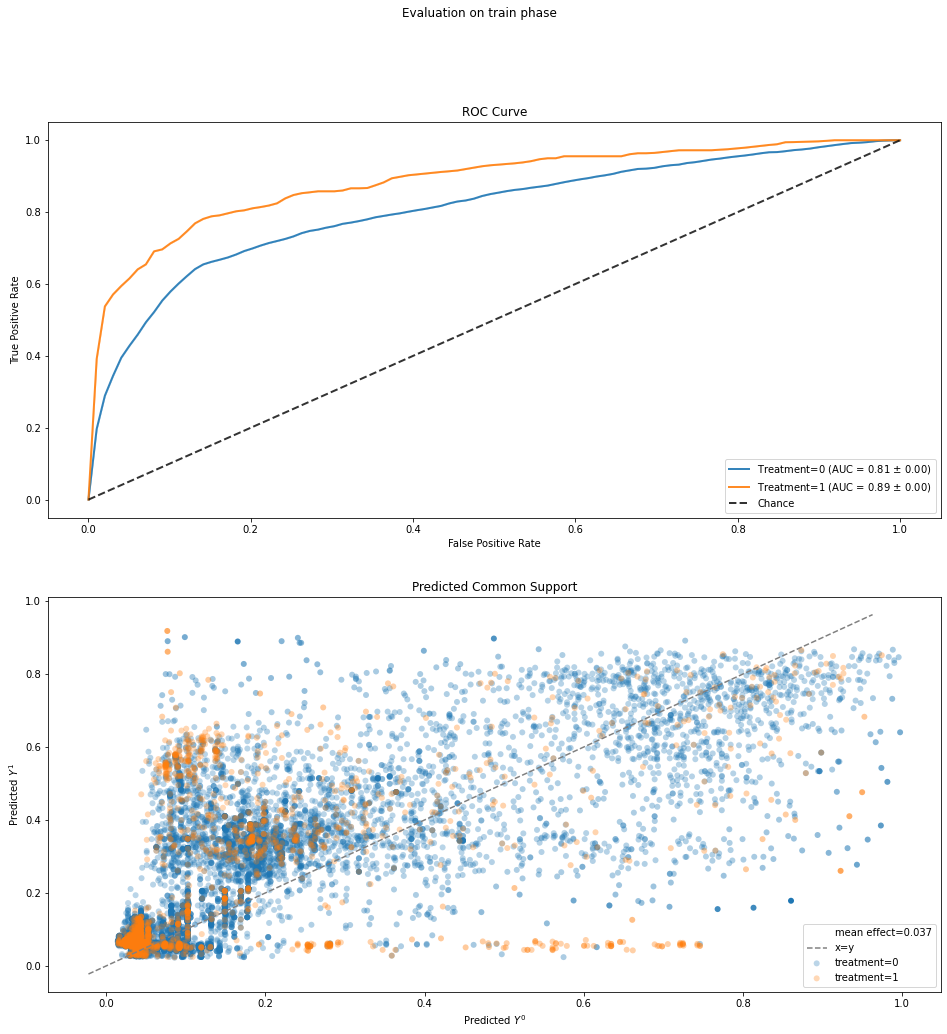

In [23]:
evaluator = OutcomeEvaluator(std)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve","common_support"])

The `OutcomeEvaluator` evaluation shows a greater discrepancy between the AUC values for the two treatment groups and also slightly less overlap between the corresponding distributions of predicted (Y<sup>0</sup>, Y<sup>1</sup>). While these discrepancies are probably not large enough to be concerning, we may wish to view the effect estimate above (which is larger than the others) with a bit more caution.

<a id='contact-summary'></a>

### Summary and comparison with non-causal analysis

Taken together, the IPW and standardization analyses support the conclusion that the causal effect of contacting a client by cell phone as opposed to landline is a 3% or slightly greater increase in the success rate, which is roughly a 25-30% increase in relative terms. Note however that this conclusion applies only to the analyzed population, excluding the period with higher inflation and short-term interest rates that had no treatment overlap.

We conclude this part by comparing this causal effect estimate to what might be obtained without a causal analysis, namely looking at the rates of positive outcomes *conditioned* on treatment assignments `a=0`, `a=1` but without adjusting for variables that could confound the effect. These conditional rates can be simply computed as:

In [25]:
y[a==0].mean(), y[a==1].mean()

(0.14737607099143207, 0.12349501203990368)

or more formally using Causal Inference 360's `MarginalOutcomeEstimator`:

In [26]:
from causallib.estimation import MarginalOutcomeEstimator
moe = MarginalOutcomeEstimator(None)
moe.fit(X, a, y)
outcomes = moe.estimate_population_outcome(X, a, y)
print(outcomes)
moe.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

1    0.123495
0    0.147376
dtype: float64


diff     0.023881
ratio    1.193377
dtype: float64

Thus it appears that a non-causal analysis would underestimate the effect of contact mode. This might be explained for example by the weaker intervention (contact by landline) being selected more often (collectively by bank employees) during better economic conditions and/or months of the year when clients may be more likely to invest in a term deposit. If this is the case, then the observational data would make the weaker intervention appear slightly stronger than it really is.

<a id='campaign'></a>

## 3. Effect of Number of Contacts

We turn now to studying the effect of the number of contacts made in the current marketing campaign, `'campaign'`, on the rate of positive outcomes. Specifically, we will estimate the success rates that would result if all clients were contacted more than once versus just once. This is a relevant question because contacting clients takes resources (e.g. employee time). Together with other inputs, the effect estimate could inform instructions to employees on whether to continue contacting clients after a first attempt, or spend their time more profitably on other tasks.

<a id='campaign-treatment-confounders'></a>

### Redefine treatment variable and potential confounders

We accordingly redefine the treatment variable `a` to be 1 if `'campaign'` is greater than 1 and 0 if `'campaign'` is equal to 1. We also have to redefine `y` to restore the non-overlap group that was excluded [above](#contact-non-overlap) when we were considering the contact mode. 

In [27]:
y = pd.Series(le.fit_transform(data['y']))
a = (data['campaign'] > 1).astype(int)
print(y.mean())
print(a.mean())

0.11265417111780131
0.5716713605904632


As for confounders, we continue to use the client characteristics, previous campaign features, and economic indicators included [before](#data-confounders).

In [28]:
confounders = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

With `'campaign'` as the treatment, we imagine that we are making the decision to stop or continue after the first contact with the client. In this scenario, the features of the last contact (`'contact'`, `'day_of_week'`, and certainly `'duration'`) may not be known, so they should not be considered as potential confounders. We will thus only add `'month'`.

In [29]:
confounders += ['month']

Re-extracting the confounders:

In [30]:
X = data[confounders]
X = pd.get_dummies(X, prefix_sep='=', drop_first=True)

<a id='campaign-closer-look'></a>

### A closer look at the intervention scenario

Let us stop and think a bit harder about the decision-making scenario, i.e., after the first contact, we either continue contacting the client or stop. The first observation is that the rate of positive outcomes can only increase by continuing, so there is no question about the sign of the treatment effect. Rather, the goal is to estimate how large the positive rate is under the decision to continue, to inform a cost-benefit analysis. 

Second, the main challenge in causal effect estimation (the "fundamental problem of causal inference") is that we generally cannot observe *counterfactual* outcomes: for individuals given intervention `a=0`, we do not observe their outcomes under `a=1`, and vice versa. In the present scenario however, we actually can deduce several counterfactual outcomes. Let us define Y<sup>0</sup> as the *potential outcome* that would result if a client were contacted only once. For clients actually contacted once (assigned `a=0`), their observed outcome `y` is the same as the potential outcome Y<sup>0</sup>. For clients contacted more than once (assigned `a=1`), if we had instead stopped after the first contact, their potential outcomes should be Y<sup>0</sup> = 0, as otherwise the bank employees would not have persisted in contacting them. Thus, Y<sup>0</sup> can be inferred for all clients as follows:

In [31]:
y0 = y * (a == 0)
y0.mean()

0.05584150723511702

This 5.6% success rate is in fact the rate under the intervention of contacting only once. We will come back to it later.

In addition, the potential outcome Y<sup>0</sup> is **known** at the time of decision after the first contact by the bank employees. It can in fact be seen as a special kind of confounder in having deterministic effects: if Y<sup>0</sup>=1 (success), then `a=0` deterministically as there is no benefit to continuing, and also `y=1`. Since clients with Y<sup>0</sup>=1 receive only treatment `a=0`, they constitute a group with **complete non-overlap** of treatments. They should therefore be excluded from the causal analysis, as we did [before in the analysis of `'contact'`](#contact-non-overlap). So we remove them:

In [32]:
y = y.loc[y0 == 0]
a = a.loc[y0 == 0]
X = X.loc[y0 == 0]
X.shape

(38888, 46)

The remaining clients with Y<sup>0</sup>=0 can receive either treatment `a=0` or `a=1`, so they do not exhibit complete non-overlap. They might still suffer from partial non-overlap, but this can be checked using an IPW model and Causal Inference 360's `PropensityEvaluator`, as we will do next.

<a id='campaign-ipw'></a>

### Inverse propensity weighting

[As in Section 2](#contact-ipw1), we will instantiate IPW with a logistic regression model for predicting the probabilities of treatment assignments.

In [33]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
#lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
#lr = GradientBoostingClassifier()
ipw = IPW(lr)
ipw.fit(X, a)

IPW(truncate_eps=None, use_stabilized=False,
    learner=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False))

Let us check the IPW model using `PropensityEvaluator`.

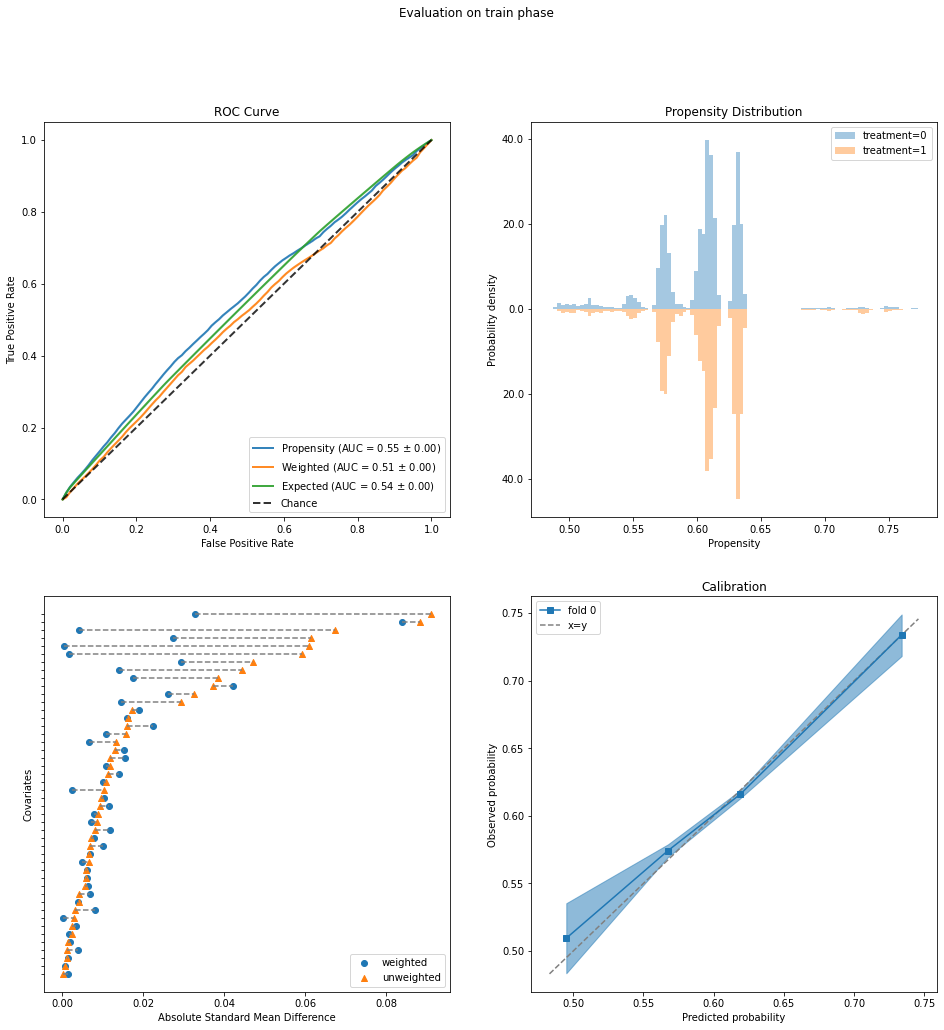

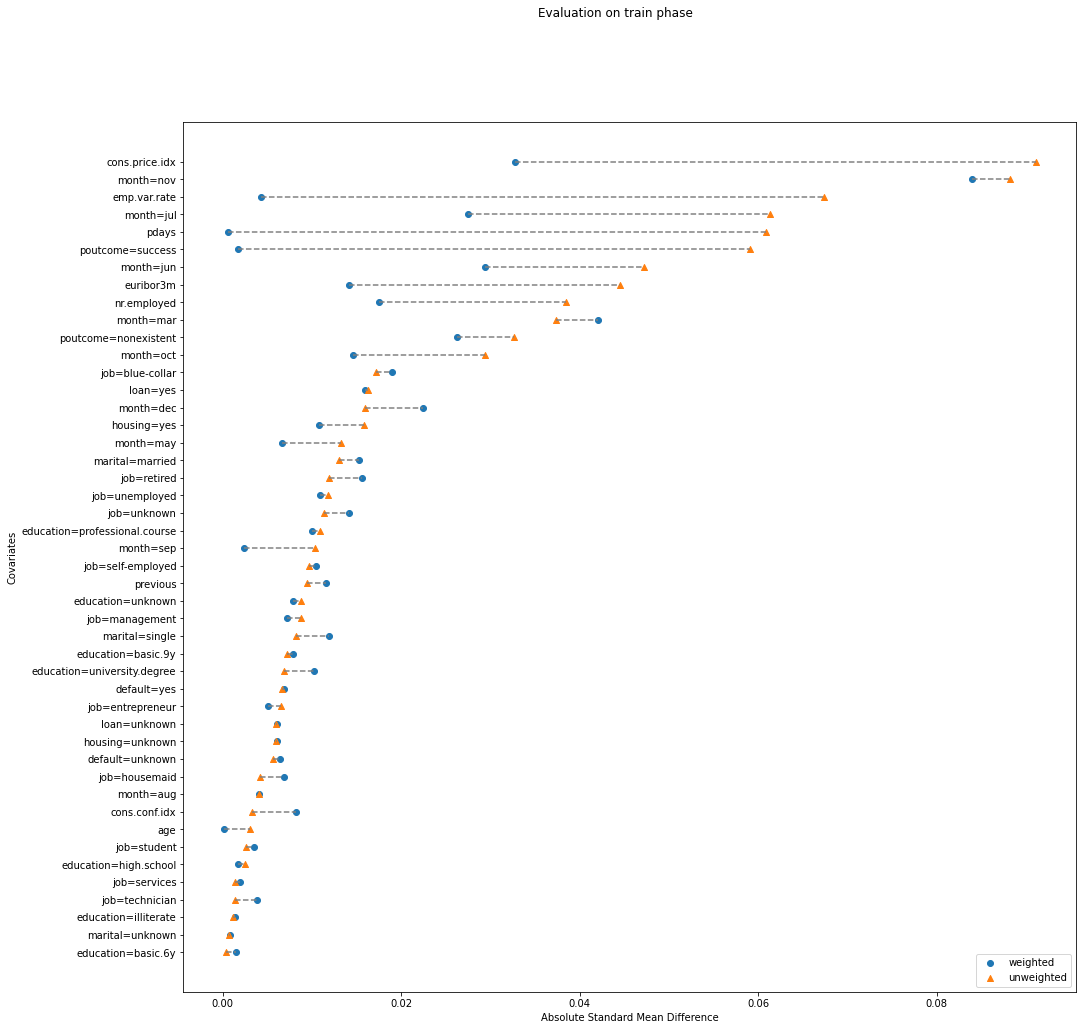

In [34]:
evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])
evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

The two treatment groups are fairly balanced to begin with: 
* **ROC Curve**: The Propensity AUC (blue curve) is only 0.55, which is further reduced to 0.51 by IPW.
* **Propensity Distribuution**: The distributions of propensity estimates are balanced.
* **Covariate Balance Love Plot**: The standardized mean differences are all below 0.1 even before IPW.

Now we obtain estimates of positive rates and the treatment effect:

In [35]:
outcomes = ipw.estimate_population_outcome(X, a, y)
print(outcomes)
ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=['diff'])

0    0.000000
1    0.100092
dtype: float64


diff    0.100092
dtype: float64

The positive rate is zero under `a=0` (stopping), as it should be for this subpopulation defined by the lack of success after one contact. Under `a=1`, the estimated success rate is 10%. We will break down this rate next using standardization.

<a id='campaign-standardization'></a>

### Standardization

Recall that in standardization, we use a regressor to predict the outcome `y` from confounders `X` and treatment `a`. Because of the exclusion of positive outcomes Y<sup>0</sup>=1 under `a=0`, `y` is now identically zero conditioned on `a=0`. Thus we need only fit a model for `a=1`. To accomplish this, we use `StratifiedStandardization` with gradient boosted classification trees as before for `a=1` and linear regression for `a=0`. The latter is a "dummy" that will just return an all-zero model.

In [36]:
from sklearn.linear_model import LinearRegression
std = StratifiedStandardization({0: LinearRegression(), 1: GradientBoostingClassifier()}, predict_proba=True)
std.fit(X, a, y)

StratifiedStandardization(learner=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

We go ahead and estimate rates of positive outcomes under the two interventions. (The last two columns of `outcomes` are the predicted probabilities of `y=0` and `y=1` under intervention `a=1` and hence add up to 1.)

In [37]:
outcomes = std.estimate_population_outcome(X, a)
print(outcomes)
std.estimate_effect(outcomes[(1,1)], outcomes[0], effect_types=['diff'])

campaign  y
0         y    0.000000
1         0    0.902173
          1    0.097827
dtype: float64


diff    0.097827
dtype: float64

The estimated outcome under the `a=0` intervention (stopping) is zero, as expected. The estimated outcome of 9.8% under `a=1` is slightly lower than that from IPW.

With standardization, we can also see whether there is a difference between the estimated success rates for the **assigned** treatment groups `a=0` and `a=1`, under the intervention of continuing contact for all clients. This can be done using the `estimate_individual_outcome` method (as opposed to `estimate_population_outcome` above), extracting the `(1,1)` column with success probabilities under the `a=1` intervention, and then averaging the probabilities over the two treatment groups.

In [38]:
yPot = std.estimate_individual_outcome(X, a)#.xs(1, axis=1, level='y')
#print(yPot.head())
y1 = yPot[(1,1)]
print('Estimated success rates under continuing contact')
print('for the "untreated" group a=0: {}'.format(y1.loc[a == 0].mean()))
print('for the "treated" group a=1: {}'.format(y1.loc[a == 1].mean()))

Estimated success rates under continuing contact
for the "untreated" group a=0: 0.0954305243595245
for the "treated" group a=1: 0.09938921214795371


The average of `y1` over the `a=0` group (the potential success rate in the "untreated") is slightly lower than that of the `a=1` group (the "treated"), which accounts for the slightly lower overall rate of 9.8% above. What this means is that if we had decided to continue contacting **all** clients, we might have had slightly less success with the clients whom the bank employees stopped contacting in the data (`a=0`) than with the clients whom they continued to contact (`a=1`). Perhaps this is because the bank employees, in deciding whom to keep contacting, had some ability to predict which clients would be more likely to invest, although we cannot say this with confidence given the small difference.

We can also verify that the estimated success rate for the `a=1` group is very close to the observed rate (since this group was actually subject to continued contact). The latter is the rate *conditioned on* `a=1`. Again, this may be what one would compute without a causal approach.

In [39]:
print(y[a==1].mean())

0.09937993714431326


<a id='campaign-summary'></a>

### Summary

Lastly, recall that we had excluded from the causal analysis clients with a positive outcome after the first contact (Y<sup>0</sup>=1). For these clients, we can assume (or define) their counterfactual outcome to be Y<sup>1</sup>=1 if we were to keep contacting them. Then we can construct a complete set of potential outcomes `y1All` under the `a=1` intervention:

In [42]:
y1All = y0.copy()
y1All[y1All == 0] = y1
print('Estimated success rate under one contact for all clients: {}'.format(y0.mean()))
print('Estimated success rate under more than one contact for all clients: {}'.format(y1All.mean()))

Estimated success rate under one contact for all clients: 0.05584150723511702
Estimated success rate under more than one contact for all clients: 0.14820611571233294


In summary, from the data we observe a 5.6% success rate after one contact, and from the causal analysis, we are predicting a success rate of 14.8% if **all** clients were subject to continued contact. The observed success rate of 11.3% lies in between since the bank employees continued contacting some clients and stopped contacting others.